In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2, influence_plot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

In [18]:
%%time
#DATA PREPARATION from professor
# Read the training dataset...
trn_df = pd.read_csv('D:\\UNIVERSITA\\lin_mod_data\\train.csv')
#sample_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
#reveal_df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')
trn_df.info()
trn_df.head()
trn_df.isnull().sum()
trn_df = trn_df.dropna(subset=['target'])
aux = trn_df.isnull().sum(axis=1).values
for i in np.unique(aux):
    print(i, np.sum(aux == i))
pred_with_8nas = np.median(trn_df[['target']].values[aux == 8])
pred_with_8nas
print(trn_df.shape)
trn_df = trn_df.drop(trn_df.index[aux == 8])
print(trn_df.shape)
auxb = aux[aux != 8]
len(auxb)
trn_df['nna'] = auxb
trn_df.describe()
values = {'imbalance_size': 0, 'imbalance_buy_sell_flag': 0, 
        'reference_price': 1, 
        'matched_size': np.nanmean(trn_df.matched_size.values),
        'far_price': 0, 'near_price': 0, 
        'bid_price': 1, 
        'bid_size': np.nanmean(trn_df.bid_size.values), 
        'ask_price': 1,
        'ask_size': np.nanmean(trn_df.ask_size.values), 
        'wap': 1}

trn_df = trn_df.fillna(value=values)
qlim = np.quantile(trn_df[['target']].values.flatten(), [0.01, 0.99])
y = np.minimum(np.maximum(trn_df[['target']].values.flatten(), qlim[0]), qlim[1])
qlim
itrain = np.arange(len(y))
k = 2 * np.pi * 4 / 540
X = np.array([np.ones((len(y))), trn_df[['wap']].values.flatten(), # 0, 1
          trn_df[['ask_size']].values.flatten(), trn_df[['bid_size']].values.flatten(), # 2, 3
          trn_df[['ask_price']].values.flatten(), trn_df[['bid_price']].values.flatten(), # 4, 5
          trn_df[['near_price']].values.flatten(), trn_df[['far_price']].values.flatten(), # 6, 7
          trn_df[['matched_size']].values.flatten(), trn_df[['reference_price']].values.flatten(), # 8, 9
          trn_df[['imbalance_size']].values.flatten() * trn_df[['imbalance_buy_sell_flag']].values.flatten(), # 10
          np.cos(trn_df[['seconds_in_bucket']].values.flatten() * k), np.sin(trn_df[['seconds_in_bucket']].values.flatten() * k), # 11, 12
          np.cos(trn_df[['seconds_in_bucket']].values.flatten() * k / 2), np.sin(trn_df[['seconds_in_bucket']].values.flatten() * k / 2), # 13, 14
          trn_df[['nna']].values.flatten(), # 15
          (trn_df[['far_price']].values.flatten() == 0) * 1.0, # 16
          (trn_df[['near_price']].values.flatten() == 0) * 1.0 ] # 17
         ).T 
X.shape
mX = np.mean(X[:, 1:11], axis=0)
sX = np.std(X[:, 1:11], axis=0)
X[:, 1:11] = (X[:, 1:11] - mX) / sX

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB
0 2343638
1 37162
2 2856960
8 132
(5237892, 17)
(5237760, 17)
Wall time: 28 s


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# INSERT DATA HERE
# Ordinary least squares
X_train = sm.add_constant(X_train)  # Add a constant term

#USES TOO MUCH MEMORY, AT LEAST ON MY PC, I HAVE TO REDUCE SUBSET SIZE
subset_size = 1000  # Adjust this to a smaller number
X_train = X_train[::subset_size, :]
X_test = X_test[::subset_size,:]
y_test=y_test[::subset_size]
y_train = y_train[::subset_size]

#X_train_subset = X_train[:, best_subset_indices[:subset_size]]
#X_test_subset = X_test[:, best_subset_indices[:subset_size]]

#X_train=X_train_subset
#X_test=X_test_subset

#X_train = X_train[:, best_subset_indices[:subset_size]]
#X_test = X_test[:, best_subset_indices[:subset_size]]


In [51]:
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# Assuming X_train is your NumPy array
print(X_train.shape)

(4191, 18)


RMSE: 7.607610558928974
Best Subset Indices: [ 2 10 18  7 17  8 16  6  5 13  3  9 11 12 14 15  4  1]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     8.847
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           9.25e-22
Time:                        18:56:44   Log-Likelihood:                -14829.
No. Observations:                4191   AIC:                         2.969e+04
Df Residuals:                    4174   BIC:                         2.980e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

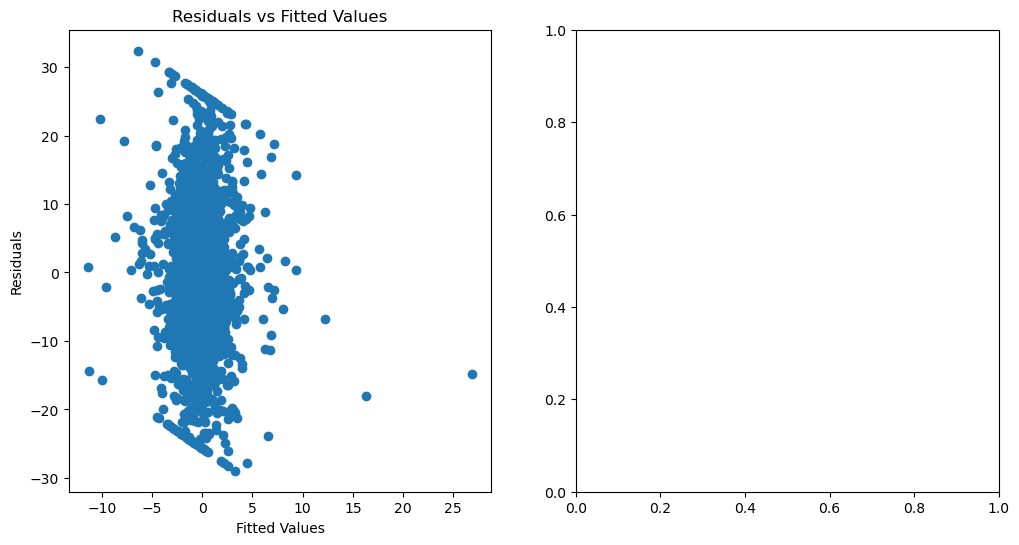

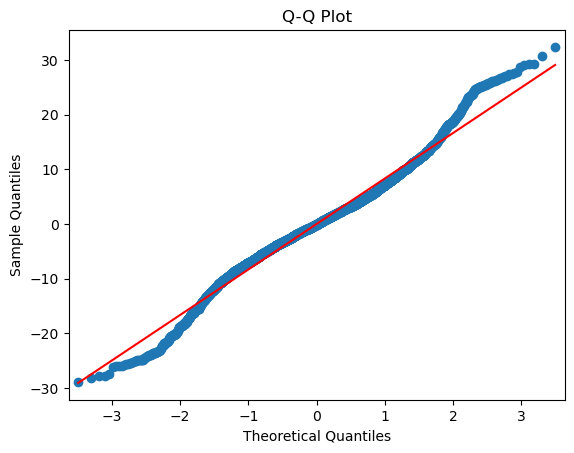

Wall time: 760 ms


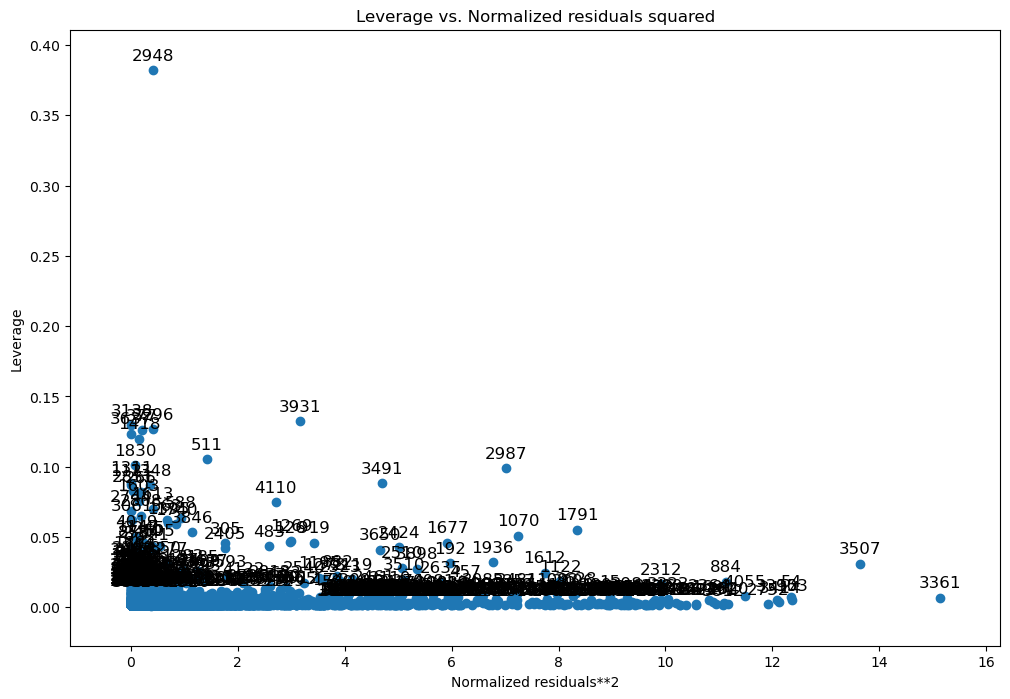

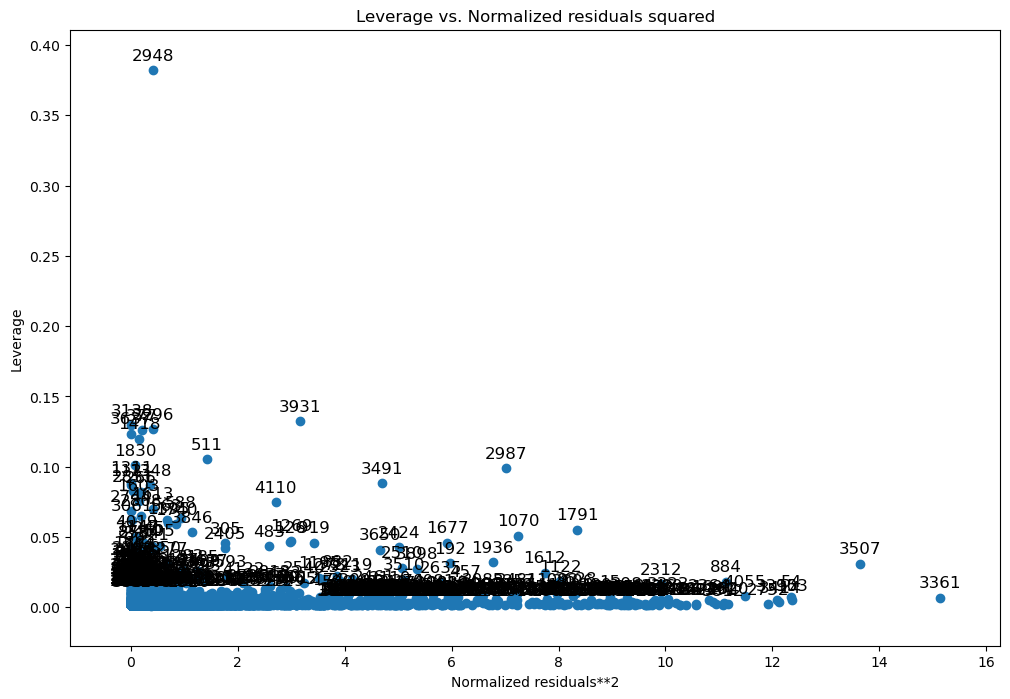

In [52]:
%%time
# Prediction
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Best subset selection
# (Note: This implementation is simplified and may not perfectly match R's leaps function)
from sklearn.feature_selection import RFE

lr = LinearRegression()
selector = RFE(lr, n_features_to_select=1)
selector.fit(X_train, y_train)

best_subset_indices = selector.ranking_
best_subset_indices = np.argsort(best_subset_indices) + 1  # Adjust for 0-based indexing
print("Best Subset Indices:", best_subset_indices)

# HERE MODIFIED Train and test the model on the best subset

best_subset_indices = [index - 1 for index in best_subset_indices]
X_train_subset = X_train[:, best_subset_indices]
model_best_subset = sm.OLS(y_train, sm.add_constant(X_train_subset)).fit()
print(model_best_subset.summary())

# Assuming X_test is a NumPy array
X_test_subset = X_test[:, best_subset_indices]
y_pred_best_subset = model_best_subset.predict(sm.add_constant(X_test_subset))
print("RMSE (Best Subset):", np.sqrt(mean_squared_error(y_test, y_pred_best_subset)))

# Diagnostics
# Residual plots
residuals = y_train - model.predict(X_train)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, residuals)
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Q-Q plot
plt.subplot(1, 2, 2)
qqplot(residuals, line='s')
plt.title("Q-Q Plot")
plt.show()

# Leverage plot and influence plot
fig, ax = plt.subplots(figsize=(12, 8))
plot_leverage_resid2(model, ax=ax)

In [54]:
#This does not produce anything
influence_plot(model, ax=ax, criterion="cooks")
plt.show()

In [53]:
%%time

# Variance inflation factors (VIF)
X_train_df = pd.DataFrame(X_train, columns=[f'var{i}' for i in range(X_train.shape[1])])
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
print(vif_data)

# Non-constant error variance test
_, p_value, _, _ = het_breuschpagan(model.resid, X_train)
print("Breusch-Pagan p-value:", p_value)

# Autocorrelation test
durbin_watson_statistic = durbin_watson(model.resid)
print("Durbin-Watson Statistic:", durbin_watson_statistic)

# Global test like in R does not exist, switched to other tests

# Heteroscedasticity Test (Breusch-Pagan)
_, p_value_bp, _, _ = het_breuschpagan(model.resid, model.model.exog)
print("Breusch-Pagan Test p-value:", p_value_bp)

# Autocorrelation Test (Durbin-Watson)
dw_statistic = durbin_watson(model.resid)
print("Durbin-Watson Statistic:", dw_statistic)

# Normality Test (Shapiro-Wilk)
shapiro_test_statistic, shapiro_p_value = shapiro(model.resid)
print("Shapiro-Wilk Test p-value:", shapiro_p_value)


   Variable          VIF
0      var0  5782.611198
1      var1   142.881134
2      var2     1.371513
3      var3     1.339760
4      var4    71.478963
5      var5    73.014797
6      var6  8647.394616
7      var7  3298.204836
8      var8     1.049689
9      var9    61.534170
10    var10     1.027422
11    var11     1.011949
12    var12     1.008333
13    var13     1.016545
14    var14     1.024428
15    var15          inf
16    var16          inf
17    var17          inf
Breusch-Pagan p-value: 2.5204953642143837e-39
Durbin-Watson Statistic: 1.9984122991894713
Breusch-Pagan Test p-value: 2.5204953642143837e-39
Durbin-Watson Statistic: 1.9984122991894713
Shapiro-Wilk Test p-value: 1.8111149867216174e-23
Wall time: 32.1 s


D:\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
